In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import optuna

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 100

df = pd.read_pickle("../data/RDKit/rdkit_only_valid_smiles_qm9.pkl")
# Check the info of the dataframe, especially important is the dtypes of the columns
# Split features and target
X = df.drop(columns=['gaps', 'SMILES']) # Drop the target variable and the SMILES objects
y = df['gaps']

In [4]:
df.info()
X.info()
X.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129012 entries, 0 to 129011
Columns: 219 entries, MaxAbsEStateIndex to gaps
dtypes: float64(108), int64(110), object(1)
memory usage: 215.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129012 entries, 0 to 129011
Columns: 217 entries, MaxAbsEStateIndex to fr_urea
dtypes: float64(107), int64(110)
memory usage: 213.6 MB


MaxAbsEStateIndex    float64
MaxEStateIndex       float64
MinAbsEStateIndex    float64
MinEStateIndex       float64
qed                  float64
                      ...   
fr_thiazole            int64
fr_thiocyan            int64
fr_thiophene           int64
fr_unbrch_alkane       int64
fr_urea                int64
Length: 217, dtype: object

In [5]:
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
len(constant_cols), constant_cols

(23,
 ['SMR_VSA8',
  'SlogP_VSA12',
  'SlogP_VSA9',
  'EState_VSA11',
  'VSA_EState10',
  'fr_C_S',
  'fr_SH',
  'fr_azide',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_prisulfonamd',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene'])

In [3]:
# --- Split ---
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# --- LightGBM Dataset ---
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# --- Parameters ---
params = {
    "objective": "regression_l1",  # MAE optimization
    "metric": "l1",                # MAE evaluation
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": seed,
    "force_col_wise": True
}

# --- Train ---
model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=valid_data,
    num_boost_round=2000
)

# --- Predict ---
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)



[LightGBM] [Info] Total Bins 21619
[LightGBM] [Info] Number of data points in the train set: 103209, number of used features: 189
[LightGBM] [Info] Start training from score 6.805567


KeyboardInterrupt: 

In [ ]:
# --- Evaluate ---
rmse = root_mean_squared_error(y_valid, y_pred)
mae  = mean_absolute_error(y_valid, y_pred)
r2   = r2_score(y_valid, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


MAE:  0.1647
RMSE: 0.2569
R²:   0.9598


In [ ]:
from sklearn.model_selection import StratifiedKFold

num_bins = 10  # 10 bins for deciles
gap_bins_outer = pd.qcut(y, q=num_bins, labels=False)
print(gap_bins_outer)
# Different seed for outer and inner CV
outer_seed = 42
inner_seed = 123

# Outer CV (train/test), 80/20 split of total dataset
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=outer_seed)

for outer_fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, gap_bins_outer)):

    #Split into train/test
    X_train_outer, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test = y.iloc[train_idx], y.iloc[test_idx]

    outer_fold = {
        "outer_fold_idx": outer_fold_idx,
        "X_test": X_test,
        "y_test": y_test,
        "inner_folds": []
    }
    
    # Create second binning that only works on the outer train data
    gap_bins_inner = pd.qcut(y_train_outer, q=num_bins, labels=False)

    # Inner CV (train/val), 72/8 split of total dataset
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=inner_seed)


    for inner_fold_idx, (inner_train_idx, val_idx) in enumerate(inner_cv.split(X_train_outer, gap_bins_inner)):

        # Split into train/validation
        X_train_inner, X_val = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[val_idx]
        y_train_inner, y_val = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[val_idx]

        inner_fold = {
            "inner_fold_idx": inner_fold_idx,
            "X_train": X_train_inner,
            "y_train": y_train_inner,
            "X_val": X_val,
            "y_val": y_val
        }

        # Append inner fold to outer fold
        outer_fold["inner_folds"].append(inner_fold)

0         9
1         9
2         9
3         9
4         9
         ..
129007    9
129008    9
129009    7
129010    8
129011    8
Name: gaps, Length: 129012, dtype: int64


In [11]:
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error


# ------------------------------------------------------
# Create stratification bins for regression
# ------------------------------------------------------
def make_stratified_bins(y, n_bins=10):
    return pd.qcut(y, q=n_bins, labels=False, duplicates="drop")


# ------------------------------------------------------
# FAST Objective for Optuna
# ------------------------------------------------------
def objective(trial, X, y, y_bins):
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }

    # 2-fold stratified inner CV
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    maes = []

    for train_idx, val_idx in inner_cv.split(X, y_bins):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, y_train)
        val_data = lgb.Dataset(X_val, y_val)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000
        )

        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))

    return np.mean(maes)


# ------------------------------------------------------
# FAST Nested CV with stratified folds
# ------------------------------------------------------
def fast_nested_cv_stratified(X, y, n_trials=10):
    # Make stratification bins
    y_bins = make_stratified_bins(y, n_bins=10)

    # 3-fold stratified outer CV
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    outer_maes = []
    best_params_list = []

    fold_num = 1
    for train_idx, test_idx in outer_cv.split(X, y_bins):
        print(f"\n=== Outer Fold {fold_num} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Recompute bins for inner fold (important!)
        y_bins_inner = make_stratified_bins(y_train, n_bins=10)

        # Inner optimization
        study = optuna.create_study(direction="minimize")
        study.optimize(
            lambda t: objective(t, X_train, y_train, y_bins_inner),
            n_trials=n_trials,
            show_progress_bar=False#,n_jobs=4
        )

        best_params = study.best_params
        best_params["objective"] = "regression"
        best_params["metric"] = "mae"
        best_params["verbosity"] = -1
        best_params_list.append(best_params)

        # Train on full outer training fold
        train_set = lgb.Dataset(X_train, y_train)
        val_set = lgb.Dataset(X_test, y_test)

        model = lgb.train(
            best_params,
            train_set,
            valid_sets=[val_set],
            num_boost_round=1000
        )

        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)

        print(f"Fold {fold_num} MAE: {mae:.4f}")
        outer_maes.append(mae)

        fold_num += 1

    return outer_maes, best_params_list


In [12]:
#early stopping and n_jobs in optuna not supported in lightgbm train API
outer_maes, best_params_list = fast_nested_cv_stratified(X, y, n_trials=100)
print("\n=== Summary of Outer Fold MAEs ===")
for i, mae in enumerate(outer_maes, 1):
    print(f"Fold {i} MAE: {mae:.4f}")
print(f"Overall MAE: {np.mean(outer_maes):.4f} ± {np.std(outer_maes):.4f}")

print(f"BEST PARAMETERS FROM EACH OUTER FOLD:")
for i, params in enumerate(best_params_list, 1):
    print(f"Outer Fold {i}: {params}")


=== Outer Fold 1 ===


[I 2025-11-21 18:41:07,454] A new study created in memory with name: no-name-83395b7e-27f3-4476-a79f-dda476a1c189
[I 2025-11-21 18:43:10,931] Trial 0 finished with value: 0.24956466112087378 and parameters: {'num_leaves': 48, 'learning_rate': 0.004424204408818223, 'feature_fraction': 0.768247336975975, 'bagging_fraction': 0.7874459562434635, 'bagging_freq': 2, 'min_data_in_leaf': 85}. Best is trial 0 with value: 0.24956466112087378.
[I 2025-11-21 18:47:20,380] Trial 1 finished with value: 0.3011652528156653 and parameters: {'num_leaves': 150, 'learning_rate': 0.0018524896020293677, 'feature_fraction': 0.7726308760437448, 'bagging_fraction': 0.960347915053823, 'bagging_freq': 4, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.24956466112087378.
[I 2025-11-21 18:54:28,711] Trial 2 finished with value: 0.17874439562436847 and parameters: {'num_leaves': 221, 'learning_rate': 0.008007817973037908, 'feature_fraction': 0.7987437615028767, 'bagging_fraction': 0.9121175541987646, 'baggin

Fold 1 MAE: 0.1493

=== Outer Fold 2 ===


[I 2025-11-21 23:37:03,237] A new study created in memory with name: no-name-75fb9f31-955c-483b-a830-8eff2d5a420a
[I 2025-11-21 23:38:33,574] Trial 0 finished with value: 0.16263261885683708 and parameters: {'num_leaves': 108, 'learning_rate': 0.0573149975936314, 'feature_fraction': 0.8411436931231845, 'bagging_fraction': 0.7269767781799124, 'bagging_freq': 1, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.16263261885683708.
[I 2025-11-21 23:41:39,236] Trial 1 finished with value: 0.158801159961671 and parameters: {'num_leaves': 235, 'learning_rate': 0.02756020410881636, 'feature_fraction': 0.8219261677981117, 'bagging_fraction': 0.9695848338913462, 'bagging_freq': 3, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.158801159961671.
[I 2025-11-21 23:44:03,562] Trial 2 finished with value: 0.15958359779424985 and parameters: {'num_leaves': 194, 'learning_rate': 0.0398245238022969, 'feature_fraction': 0.8250455478104205, 'bagging_fraction': 0.7930420862707847, 'bagging_freq

Fold 2 MAE: 0.1482

=== Outer Fold 3 ===


[I 2025-11-22 03:50:43,846] A new study created in memory with name: no-name-95b45747-0d60-4d23-a6a9-189c7100b767
[I 2025-11-22 03:52:15,529] Trial 0 finished with value: 0.25200509564817675 and parameters: {'num_leaves': 47, 'learning_rate': 0.0042523495187018695, 'feature_fraction': 0.9172132716650746, 'bagging_fraction': 0.7257100875325353, 'bagging_freq': 1, 'min_data_in_leaf': 21}. Best is trial 0 with value: 0.25200509564817675.
[I 2025-11-22 03:54:29,592] Trial 1 finished with value: 0.22270423841932754 and parameters: {'num_leaves': 104, 'learning_rate': 0.004245632422092102, 'feature_fraction': 0.9003662974466862, 'bagging_fraction': 0.7607576122259657, 'bagging_freq': 3, 'min_data_in_leaf': 64}. Best is trial 1 with value: 0.22270423841932754.
[I 2025-11-22 03:56:27,304] Trial 2 finished with value: 0.2954240815369032 and parameters: {'num_leaves': 65, 'learning_rate': 0.0022711779895809568, 'feature_fraction': 0.7937939251095862, 'bagging_fraction': 0.9907517326988058, 'bagg

Fold 3 MAE: 0.1483

=== Summary of Outer Fold MAEs ===
Fold 1 MAE: 0.1493
Fold 2 MAE: 0.1482
Fold 3 MAE: 0.1483
Overall MAE: 0.1486 ± 0.0005
BEST PARAMETERS FROM EACH OUTER FOLD:
Outer Fold 1: {'num_leaves': 237, 'learning_rate': 0.05283272421443799, 'feature_fraction': 0.7285176273657754, 'bagging_fraction': 0.9888976341447224, 'bagging_freq': 5, 'min_data_in_leaf': 10, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Outer Fold 2: {'num_leaves': 256, 'learning_rate': 0.056054176083826915, 'feature_fraction': 0.7112863838847365, 'bagging_fraction': 0.9602787441530835, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Outer Fold 3: {'num_leaves': 247, 'learning_rate': 0.05328143741461067, 'feature_fraction': 0.7835672031599564, 'bagging_fraction': 0.9145047641787873, 'bagging_freq': 3, 'min_data_in_leaf': 29, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}


this is a second try where i try to store data in cvs files, afterwards we can analyse what is happening. 

In [2]:
output_folder = "/workspace/code/data/LightGBM/Optuna_cvs"  # <<< MODIFY THIS

# Make sure folder exists
import os
os.makedirs(output_folder, exist_ok=True)

In [5]:
import os
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

# ------------------------------------------------------
# Settings / Seed
# ------------------------------------------------------
seed = 100
np.random.seed(seed)

# ------------------------------------------------------
# Load Data
# ------------------------------------------------------
df = pd.read_pickle("../data/RDKit/rdkit_only_valid_smiles_qm9.pkl")

X = df.drop(columns=['gaps', 'SMILES'])
y = df['gaps']

# ------------------------------------------------------
# Stratification for Regression
# ------------------------------------------------------
def make_stratified_bins(y, n_bins=10):
    """
    Creates quantile bins for stratified k-fold in regression.
    """
    return pd.qcut(y, q=n_bins, labels=False, duplicates="drop")

# ------------------------------------------------------
# Optuna Objective
# ------------------------------------------------------
def objective(trial, X, y, y_bins):
    
    params = {
        "objective": "regression_l1",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    maes = []

    for train_idx, val_idx in inner_cv.split(X, y_bins):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, y_train)
        val_data = lgb.Dataset(X_val, y_val)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1500,
        )

        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))

    return np.mean(maes)

# ------------------------------------------------------
# Nested CV
# ------------------------------------------------------
def fast_nested_cv_stratified(X, y, n_trials=50, output_folder="./results/"):

    os.makedirs(output_folder, exist_ok=True)

    y_bins = make_stratified_bins(y, n_bins=30)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    outer_maes = []
    best_params_list = []
    all_fold_results = []

    fold_num = 1

    for train_idx, test_idx in outer_cv.split(X, y_bins):

        print(f"\n=== Outer Fold {fold_num} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        y_bins_inner = make_stratified_bins(y_train, n_bins=30)

        # Inner Optuna search
        study = optuna.create_study(direction="minimize")
        study.optimize(
            lambda t: objective(t, X_train, y_train, y_bins_inner),
            n_trials=n_trials
        )

        # Save Optuna trial history
        df_trials = study.trials_dataframe()
        df_trials.to_csv(f"{output_folder}/optuna_outer_fold_{fold_num}.csv", index=False)

        best_params = study.best_params
        best_params["verbosity"] = -1
        best_params["metric"] = "mae"
        best_params_list.append(best_params)

        # Train final model
        train_set = lgb.Dataset(X_train, y_train)
        test_set = lgb.Dataset(X_test, y_test)

        model = lgb.train(
            best_params,
            train_set,
            valid_sets=[test_set],
            num_boost_round=2000,
        )

        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        outer_maes.append(mae)

        print(f"Fold {fold_num} MAE: {mae:.4f}")

        # Save predictions
        df_pred = pd.DataFrame({
            "true": y_test.values,
            "pred": preds,
            "fold": fold_num,
        })
        df_pred.to_csv(f"{output_folder}/fold_{fold_num}_predictions.csv", index=False)

        # Save feature importances
        fi = pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importance(),
        })
        fi.to_csv(f"{output_folder}/fold_{fold_num}_feature_importance.csv", index=False)

        all_fold_results.append(df_pred)
        fold_num += 1

    return outer_maes, best_params_list, all_fold_results

# ------------------------------------------------------
# Run Nested CV
# ------------------------------------------------------
outer_maes, best_params_list, all_fold_results = fast_nested_cv_stratified(X, y)

print("\n=== Summary of Outer Fold MAEs ===")
for i, mae in enumerate(outer_maes, 1):
    print(f"Fold {i} MAE: {mae:.4f}")

print(f"Overall MAE: {np.mean(outer_maes):.4f} ± {np.std(outer_maes):.4f}")

print("\nBEST PARAMETERS PER OUTER FOLD:")
for i, params in enumerate(best_params_list, 1):
    print(f"Fold {i}: {params}")



=== Outer Fold 1 ===


[I 2025-12-06 16:41:26,743] A new study created in memory with name: no-name-b417e750-ba90-4afa-b0aa-5f418d7e077d
[I 2025-12-06 17:36:29,255] Trial 0 finished with value: 0.209299131349503 and parameters: {'num_leaves': 82, 'learning_rate': 0.0049870907285596905, 'feature_fraction': 0.9462428653783523, 'bagging_fraction': 0.764194141800638, 'bagging_freq': 3, 'min_data_in_leaf': 93}. Best is trial 0 with value: 0.209299131349503.
[I 2025-12-06 18:00:29,367] Trial 1 finished with value: 0.17270350549577415 and parameters: {'num_leaves': 42, 'learning_rate': 0.06490232225015537, 'feature_fraction': 0.8802843256662316, 'bagging_fraction': 0.8946036437827809, 'bagging_freq': 4, 'min_data_in_leaf': 46}. Best is trial 1 with value: 0.17270350549577415.
[I 2025-12-06 18:18:04,320] Trial 2 finished with value: 0.1691929964815168 and parameters: {'num_leaves': 122, 'learning_rate': 0.02116963653823926, 'feature_fraction': 0.825434914267058, 'bagging_fraction': 0.9061465820406872, 'bagging_freq'

Fold 1 MAE: 0.1417

=== Outer Fold 2 ===


[I 2025-12-07 03:45:02,724] A new study created in memory with name: no-name-3a90456a-70ee-448c-8a57-e7dfc053f107
[I 2025-12-07 03:58:43,503] Trial 0 finished with value: 0.17342074926836465 and parameters: {'num_leaves': 232, 'learning_rate': 0.00744666501919809, 'feature_fraction': 0.7167097771884452, 'bagging_fraction': 0.8487414144205976, 'bagging_freq': 5, 'min_data_in_leaf': 48}. Best is trial 0 with value: 0.17342074926836465.
[I 2025-12-07 04:14:44,630] Trial 1 finished with value: 0.334064756693231 and parameters: {'num_leaves': 226, 'learning_rate': 0.0011526786202366989, 'feature_fraction': 0.8814418697469981, 'bagging_fraction': 0.7717099556113427, 'bagging_freq': 3, 'min_data_in_leaf': 21}. Best is trial 0 with value: 0.17342074926836465.
[I 2025-12-07 04:26:55,266] Trial 2 finished with value: 0.28831750643904364 and parameters: {'num_leaves': 124, 'learning_rate': 0.0015575518550132435, 'feature_fraction': 0.7155477140044098, 'bagging_fraction': 0.8914997231202796, 'bagg

Fold 2 MAE: 0.1408

=== Outer Fold 3 ===


[I 2025-12-07 13:35:41,041] A new study created in memory with name: no-name-d9a19954-8f11-42a2-8e7c-028453b189e0
[I 2025-12-07 13:46:05,609] Trial 0 finished with value: 0.16046125160874775 and parameters: {'num_leaves': 173, 'learning_rate': 0.07914645253886592, 'feature_fraction': 0.9125141011156918, 'bagging_fraction': 0.7217921997427452, 'bagging_freq': 5, 'min_data_in_leaf': 76}. Best is trial 0 with value: 0.16046125160874775.
[I 2025-12-07 13:56:14,262] Trial 1 finished with value: 0.2108651328115298 and parameters: {'num_leaves': 66, 'learning_rate': 0.0055407898128361, 'feature_fraction': 0.8815758807648181, 'bagging_fraction': 0.9862320670132045, 'bagging_freq': 2, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.16046125160874775.
[I 2025-12-07 14:11:54,573] Trial 2 finished with value: 0.1905889379636941 and parameters: {'num_leaves': 177, 'learning_rate': 0.0044915824004239805, 'feature_fraction': 0.9668949928741443, 'bagging_fraction': 0.9259883638283968, 'bagging_

Fold 3 MAE: 0.1411

=== Outer Fold 4 ===


[I 2025-12-07 22:57:32,061] A new study created in memory with name: no-name-5b982c59-e75e-424e-85a8-74f09aae0b7f
[I 2025-12-07 23:15:02,539] Trial 0 finished with value: 0.2045215461157664 and parameters: {'num_leaves': 237, 'learning_rate': 0.0028138226462603817, 'feature_fraction': 0.8738316262540823, 'bagging_fraction': 0.8670572480016119, 'bagging_freq': 4, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.2045215461157664.
[I 2025-12-07 23:26:10,121] Trial 1 finished with value: 0.27720281355292037 and parameters: {'num_leaves': 83, 'learning_rate': 0.0018247276397552596, 'feature_fraction': 0.8544018541759384, 'bagging_fraction': 0.8771973122432484, 'bagging_freq': 2, 'min_data_in_leaf': 58}. Best is trial 0 with value: 0.2045215461157664.
[I 2025-12-07 23:33:15,668] Trial 2 finished with value: 0.19598403598201758 and parameters: {'num_leaves': 52, 'learning_rate': 0.012465704202126882, 'feature_fraction': 0.8668118849431821, 'bagging_fraction': 0.8762248747809818, 'baggin

Fold 4 MAE: 0.1430

=== Outer Fold 5 ===


[I 2025-12-08 09:05:59,627] A new study created in memory with name: no-name-2dc752fa-522d-4864-8c45-83178c25c404
[I 2025-12-08 09:20:19,717] Trial 0 finished with value: 0.16122292701276486 and parameters: {'num_leaves': 216, 'learning_rate': 0.023569229435299183, 'feature_fraction': 0.820911515412293, 'bagging_fraction': 0.8986079517197119, 'bagging_freq': 4, 'min_data_in_leaf': 59}. Best is trial 0 with value: 0.16122292701276486.
[I 2025-12-08 09:36:01,326] Trial 1 finished with value: 0.16343153810687322 and parameters: {'num_leaves': 223, 'learning_rate': 0.029123401623202535, 'feature_fraction': 0.8924297554100104, 'bagging_fraction': 0.7045365501575446, 'bagging_freq': 5, 'min_data_in_leaf': 91}. Best is trial 0 with value: 0.16122292701276486.
[I 2025-12-08 09:43:46,157] Trial 2 finished with value: 0.17560664226923142 and parameters: {'num_leaves': 66, 'learning_rate': 0.027886669964724144, 'feature_fraction': 0.8329305409725136, 'bagging_fraction': 0.8785978741719486, 'baggi

Fold 5 MAE: 0.1423

=== Summary of Outer Fold MAEs ===
Fold 1 MAE: 0.1417
Fold 2 MAE: 0.1408
Fold 3 MAE: 0.1411
Fold 4 MAE: 0.1430
Fold 5 MAE: 0.1423
Overall MAE: 0.1418 ± 0.0008

BEST PARAMETERS PER OUTER FOLD:
Fold 1: {'num_leaves': 244, 'learning_rate': 0.07321816510351337, 'feature_fraction': 0.834631822588647, 'bagging_fraction': 0.9208924098748327, 'bagging_freq': 5, 'min_data_in_leaf': 31, 'verbosity': -1, 'metric': 'mae'}
Fold 2: {'num_leaves': 239, 'learning_rate': 0.07578027741042573, 'feature_fraction': 0.7767958495344323, 'bagging_fraction': 0.9225552909296242, 'bagging_freq': 4, 'min_data_in_leaf': 26, 'verbosity': -1, 'metric': 'mae'}
Fold 3: {'num_leaves': 231, 'learning_rate': 0.08982961244272815, 'feature_fraction': 0.7355949667918182, 'bagging_fraction': 0.9978645173144768, 'bagging_freq': 4, 'min_data_in_leaf': 35, 'verbosity': -1, 'metric': 'mae'}
Fold 4: {'num_leaves': 240, 'learning_rate': 0.04635044026286379, 'feature_fraction': 0.9018367769740792, 'bagging_fract

In [6]:
# ===============================================
# Train FINAL model on the full dataset
# ===============================================

# Choose the best params from the best fold
best_index = np.argmin(outer_maes)
final_params = best_params_list[best_index]

print("Using best parameters from outer fold:", best_index + 1)
print(final_params)

# Train on full dataset
train_set_full = lgb.Dataset(X, y)

final_model = lgb.train(
    final_params,
    train_set_full,
    num_boost_round=2500
)

# Save model
final_model.save_model("final_full_dataset_model.txt")
print("Final model saved.")

final_preds = final_model.predict(X)

df_final = pd.DataFrame({
    "true": y,
    "pred": final_preds
})
df_final.to_csv("final_dataset_predictions.csv", index=False)


Using best parameters from outer fold: 2
{'num_leaves': 239, 'learning_rate': 0.07578027741042573, 'feature_fraction': 0.7767958495344323, 'bagging_fraction': 0.9225552909296242, 'bagging_freq': 4, 'min_data_in_leaf': 26, 'verbosity': -1, 'metric': 'mae'}
Final model saved.


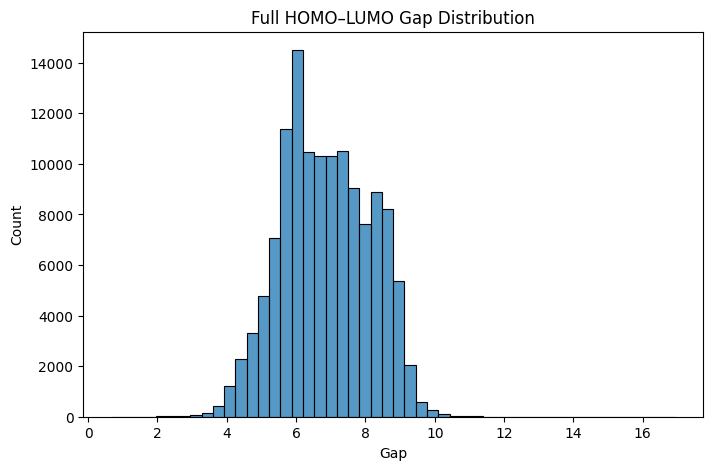

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(y, bins=50)
plt.title("Full HOMO–LUMO Gap Distribution")
plt.xlabel("Gap")
plt.ylabel("Count")
plt.show()


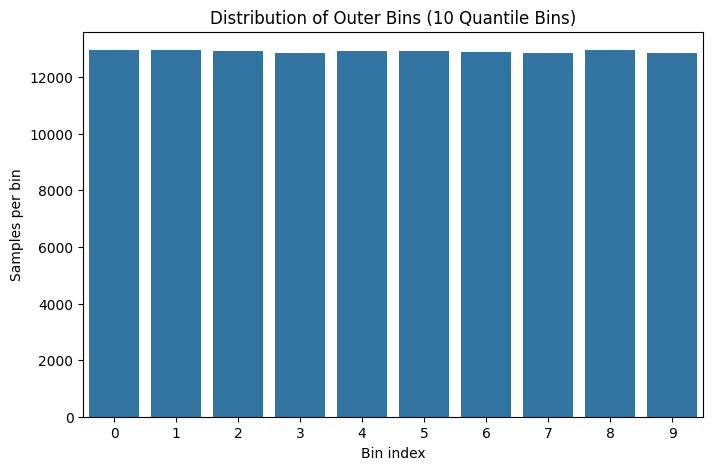

In [15]:
y_bins = make_stratified_bins(y, n_bins=10)

plt.figure(figsize=(8,5))
sns.countplot(x=y_bins)
plt.title("Distribution of Outer Bins (10 Quantile Bins)")
plt.xlabel("Bin index")
plt.ylabel("Samples per bin")
plt.show()


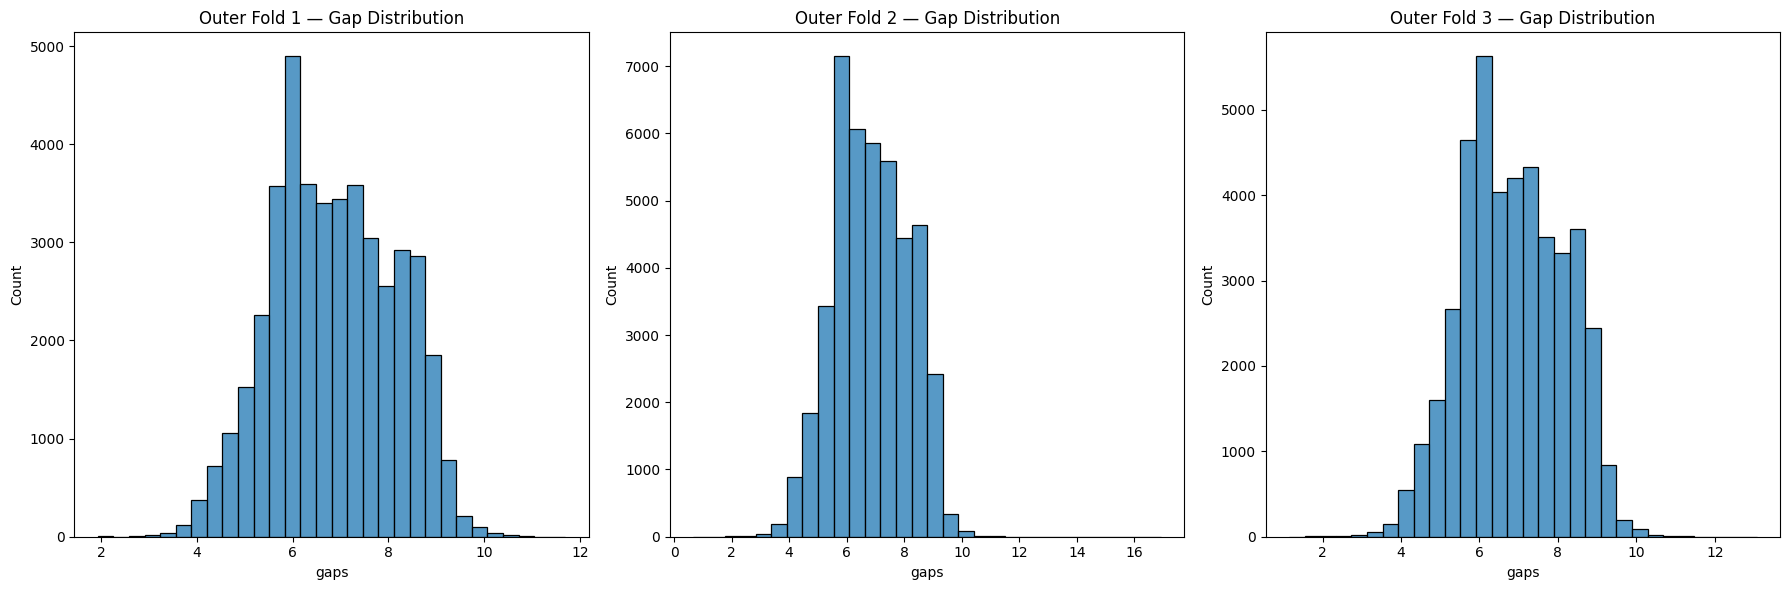

In [20]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

plt.figure(figsize=(18,6))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_bins), 1):
    plt.subplot(1, 3, fold)
    sns.histplot(y.iloc[test_idx], bins=30)
    plt.title(f"Outer Fold {fold} — Gap Distribution")

plt.tight_layout()
plt.show()


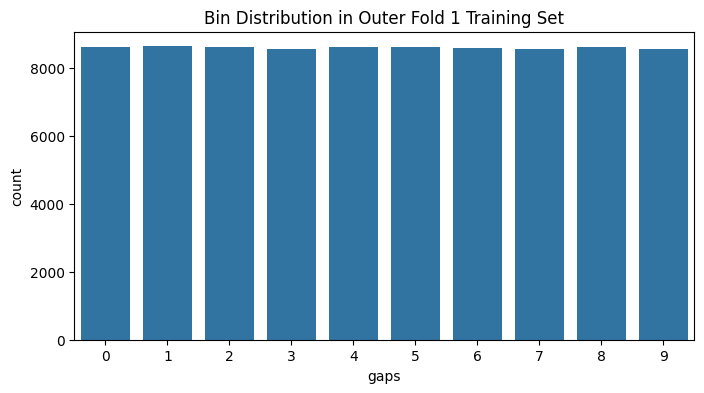

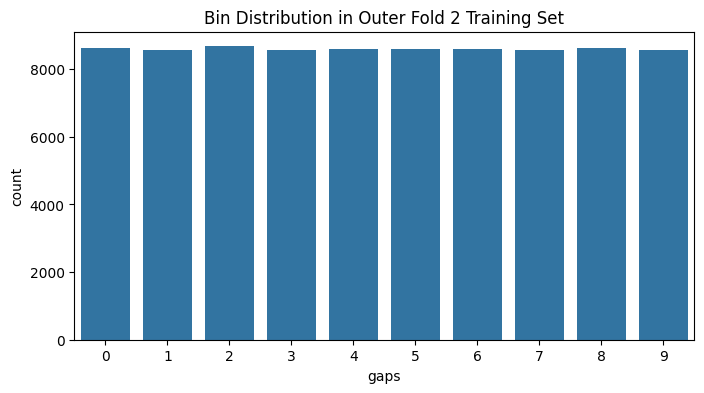

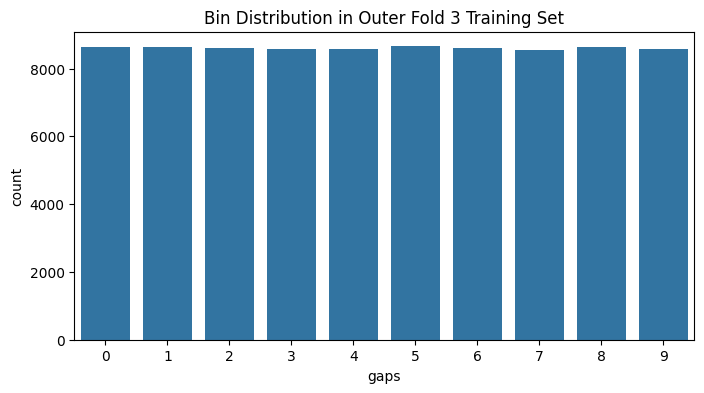

In [21]:
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_bins), 1):
    y_train_bins = make_stratified_bins(y.iloc[train_idx], n_bins=10)
    plt.figure(figsize=(8,4))
    sns.countplot(x=y_train_bins)
    plt.title(f"Bin Distribution in Outer Fold {fold} Training Set")
    plt.show()


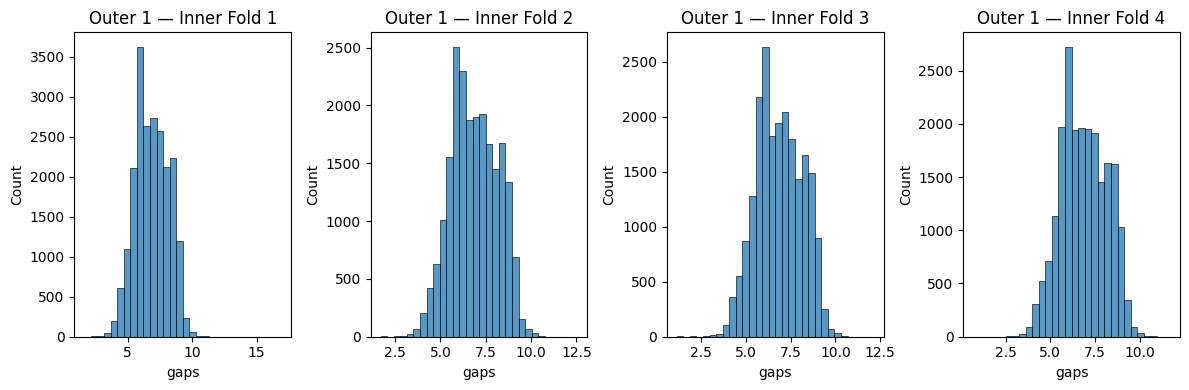

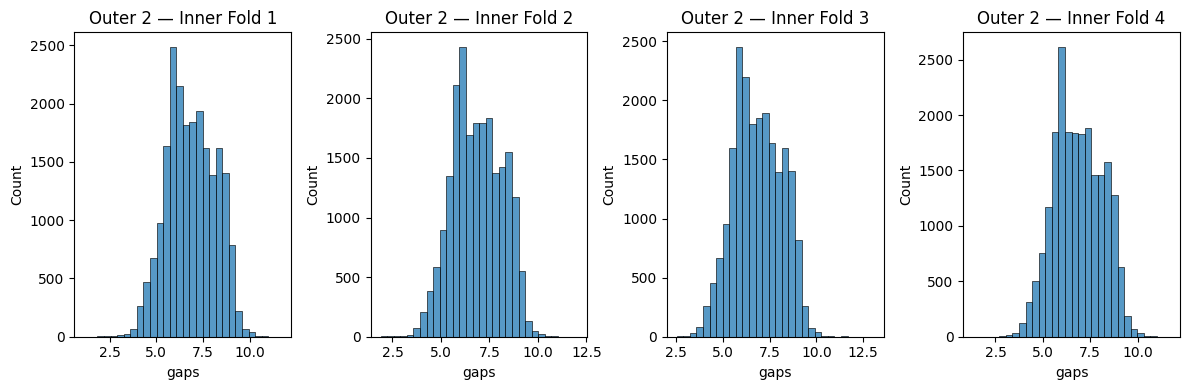

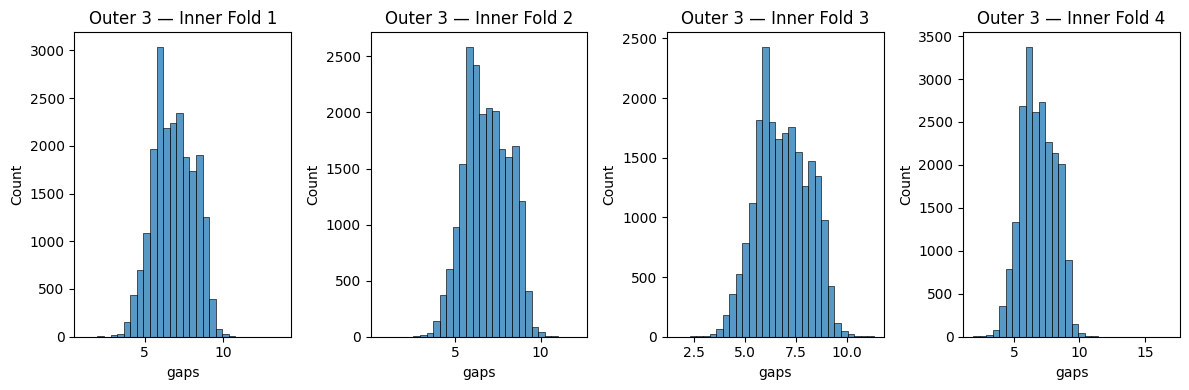

In [23]:
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_bins), 1):
    y_train_outer = y.iloc[train_idx]
    y_bins_inner = make_stratified_bins(y_train_outer, n_bins=10)
    
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    
    plt.figure(figsize=(12,4))
    for inner_fold, (_, val_idx) in enumerate(inner_cv.split(X.iloc[train_idx], y_bins_inner), 1):
        plt.subplot(1, 4, inner_fold)
        sns.histplot(y_train_outer.iloc[val_idx], bins=30)
        plt.title(f"Outer {fold} — Inner Fold {inner_fold}")

    plt.tight_layout()
    plt.show()
